In [27]:
import sys
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
import torch
import episcanpy.api as epi
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
import os

current_dir = os.getcwd()

src_path = os.path.abspath(os.path.join(current_dir, '../../src'))


if src_path not in sys.path:
    sys.path.append(src_path)


In [3]:
import SpaDiffusion as spt

In [ ]:
slice_name_list =['E15_5-S1','E15_5-S2'] 

# load raw data
cas_dict = {}
for sample in slice_name_list:
    sample_data = ad.read_h5ad('data/'+'To_train_' + sample + '_atac.h5ad')
    cas_dict[sample] = sample_data
cas_list = [cas_dict[sample] for sample in slice_name_list]
# merge peaks

In [5]:
cas_list[0]

AnnData object with n_obs × n_vars = 1949 × 265014
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

In [6]:
cas_list[0].var_names

Index(['chr1:3094810-3095311', 'chr1:3120251-3120752', 'chr1:3184960-3185461',
       'chr1:3360849-3361350', 'chr1:3399870-3400371', 'chr1:3414009-3414510',
       'chr1:3514678-3515179', 'chr1:3552386-3552887', 'chr1:3670824-3671325',
       'chr1:3671548-3672049',
       ...
       'chrY:90799093-90799594', 'chrY:90800223-90800724',
       'chrY:90801342-90801843', 'chrY:90803330-90803831',
       'chrY:90807496-90807997', 'chrY:90808593-90809094',
       'chrY:90810719-90811220', 'chrY:90811533-90812034',
       'chrY:90812148-90812649', 'chrY:90812685-90813186'],
      dtype='object', name='index', length=265014)

In [7]:
cas_list_new = spt.peak_sets_alignment(cas_list)

Peak merged
Peak filtered
Matrix merged


In [8]:
cas_list = cas_list_new

In [9]:
for j in range(len(cas_list)):
    cas_list[j].obs_names = [x + '_' + slice_name_list[j] for x in cas_list[j].obs_names]

# concatenation
adata_concat = ad.concat(cas_list, label="slice_name", keys=slice_name_list)

In [10]:
# from SpaTranslator.utils import preprocess_CAS
spt.preprocess_CAS(cas_list, adata_concat, use_fragment_count=True, min_cells_rate=0.03)

In [11]:
for i in range(len(slice_name_list)):
    cas_list[i].write_h5ad("data/filtered_merged_"+slice_name_list[i]+"_atac.h5ad")

In [ ]:
Batch_list = []
adj_list = []
section_ids = ['E15_5-S1_atac','E15_5-S2_atac']
for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad("data/filtered_merged_"+ section_id + '.h5ad')
    adata.var_names_make_unique()
    spt.build_spatial_graph(adata, knn_neighbors = 6, method ='KNN')
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=15000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj_matrix'])
    Batch_list.append(adata)
    print(adata.shape)

E15_5-S1_atac
Constructing the spatial graph
Generated graph with 11694 edges across 1949 cells.
Average neighbors per cell: 6.0000
(1949, 15000)
E15_5-S2_atac
Constructing the spatial graph
Generated graph with 11634 edges across 1939 cells.
Average neighbors per cell: 6.0000
(1939, 15000)


In [13]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat

AnnData object with n_obs × n_vars = 3888 × 7199
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'cell_type', 'slice_name'
    obsm: 'insertion', 'spatial'

In [14]:
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (3888, 7199)


In [15]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

In [16]:
adata_concat = spt.train_spatial_aligner(adata_concat, verbose=True, knn_neighbors = 50, device=used_device)

SpaDiffusion_Aligner(
  (encoder_layer1): GraphAttentionLayer(7199, 512, heads=1)
  (encoder_layer2): GraphAttentionLayer(512, 256, heads=1)
  (decoder_layer1): GraphAttentionLayer(256, 512, heads=1)
  (decoder_layer2): GraphAttentionLayer(512, 7199, heads=1)
)
Pretraining


100%|██████████| 500/500 [00:22<00:00, 21.78it/s]


Training with MNN loss


100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


In [17]:
adata_concat.X.toarray()

array([[0.68847783, 0.08623467, 0.        , ..., 0.        , 0.0440466 ,
        0.        ],
       [0.72434698, 0.2020181 , 0.        , ..., 0.10610181, 0.        ,
        0.        ],
       [0.79464059, 0.0926627 , 0.        , ..., 0.0926627 , 0.        ,
        0.04740426],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

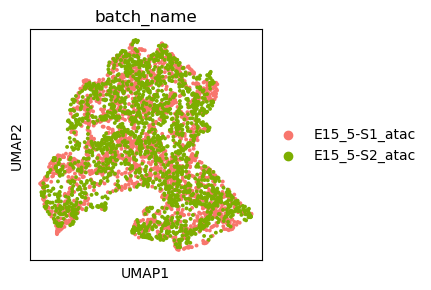

In [28]:
sc.pp.neighbors(adata_concat, use_rep='AlignedEmbedding', random_state=666)
sc.tl.umap(adata_concat, random_state=666)
section_color = ['#f8766d', '#7cae00']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_concat, color='batch_name',ncols = 1,
           wspace=0.5, show=True)

In [19]:
adata_concat.obsm['AlignedEmbedding'].shape

(3888, 256)

In [20]:
adata_concat

AnnData object with n_obs × n_vars = 3888 × 7199
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'cell_type', 'slice_name', 'batch_name'
    uns: 'edgeList', 'neighbors', 'umap', 'batch_name_colors'
    obsm: 'insertion', 'spatial', 'SpaAligner', 'AlignedEmbedding', 'X_umap'
    obsp: 'distances', 'connectivities'

In [21]:
adata_concat.obs['slice_name']

GCCGCAACGCCGCAAC-1_E15_5-S1    E15_5-S1_atac
GCCATTCTGCCATTCT-1_E15_5-S1    E15_5-S1_atac
TGCGGACCTGCGGACC-1_E15_5-S1    E15_5-S1_atac
ACTATGCAACTATGCA-1_E15_5-S1    E15_5-S1_atac
TAGATCTATAGATCTA-1_E15_5-S1    E15_5-S1_atac
                                   ...      
TTATTCATGAAGATCG-1_E15_5-S2    E15_5-S2_atac
TTATTCATATAAGGAG-1_E15_5-S2    E15_5-S2_atac
ATCATATTTCCGGCCT-1_E15_5-S2    E15_5-S2_atac
ACTTAACCGGTATGCT-1_E15_5-S2    E15_5-S2_atac
GCCGCAACATAAGGAG-1_E15_5-S2    E15_5-S2_atac
Name: slice_name, Length: 3888, dtype: category
Categories (2, object): ['E15_5-S1_atac', 'E15_5-S2_atac']

# Save the Results and Embeddings

In [ ]:
E15_S1 = sc.read_h5ad('data/To_train_' + 'E15_5-S1'+ '_atac.h5ad')
E15_S1

AnnData object with n_obs × n_vars = 1949 × 265014
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

In [23]:
E15_S1.obsm['AlignedEmbedding'] = adata_concat.obsm['AlignedEmbedding'][0:1949, :]
E15_S1.write_h5ad('data/'+'After_train_' + 'E15_5-S1' + '_atac.h5ad')

In [ ]:
E15_S2 = sc.read_h5ad('data/To_train_' + 'E15_5-S2'+ '_atac.h5ad')
E15_S2

AnnData object with n_obs × n_vars = 1939 × 244394
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'sample', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'Combined_Clusters', 'RNA_Clusters', 'ATAC_Clusters', 'cell_type'
    uns: 'peaks', 'reference_sequences'
    obsm: 'insertion', 'spatial'

In [25]:
adata_concat.obsm['AlignedEmbedding'][1949:, :].shape
adata_concat.obs['slice_name'].iloc[1949:]

GCAGGTCCGCAGGTCC-1_E15_5-S2    E15_5-S2_atac
TAGATCTATAGATCTA-1_E15_5-S2    E15_5-S2_atac
CAACCGCTCAACCGCT-1_E15_5-S2    E15_5-S2_atac
TAGAGTAATAGAGTAA-1_E15_5-S2    E15_5-S2_atac
ACTATGCAACTATGCA-1_E15_5-S2    E15_5-S2_atac
                                   ...      
TTATTCATGAAGATCG-1_E15_5-S2    E15_5-S2_atac
TTATTCATATAAGGAG-1_E15_5-S2    E15_5-S2_atac
ATCATATTTCCGGCCT-1_E15_5-S2    E15_5-S2_atac
ACTTAACCGGTATGCT-1_E15_5-S2    E15_5-S2_atac
GCCGCAACATAAGGAG-1_E15_5-S2    E15_5-S2_atac
Name: slice_name, Length: 1939, dtype: category
Categories (2, object): ['E15_5-S1_atac', 'E15_5-S2_atac']

In [26]:
E15_S2.obsm['AlignedEmbedding'] = adata_concat.obsm['AlignedEmbedding'][1949:, :]
E15_S2.write_h5ad('data/'+'After_train_' + 'E15_5-S2' + '_atac.h5ad')